# Base de dados Iris

In [159]:
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree

iris = load_iris()
X, y = iris.data[:,2:], iris.target
X.shape, y.shape

((150, 2), (150,))

# Minha heurística escolhida

Usei os conceitos de entropia e ganho de informação para montar a árvore

In [160]:
def entropia(y):
    entropia = 0
    classes = np.unique(y)
    
    for classe in classes:
        proporcao = np.mean(y == classe)                
        entropia -= proporcao * np.log2(proporcao)
    
    return entropia

In [161]:
def ganho(x, y):

    media_valores = np.mean(x)               
    maiores = x > media_valores 
    total = sum(maiores) + sum(~maiores)    
    prop_maiores = sum(maiores)/total
    prop_menores = sum(~maiores)/total
    '''print('entropia geral: ',entropia(y))
    print('prop_maiores: ', prop_maiores) 
    print('prop_menores: ', prop_menores)
    print('entropia(y[maiores]): ', entropia(y[maiores]))
    print('entropia(y[~maiores]): ', entropia(y[~maiores]))    '''
    return entropia(y) - prop_maiores*entropia(y[maiores]) - prop_menores*entropia(y[~maiores])

def caracteristica_maior_ganho(X, y):
    maior_ganho = 0
    caracteristica = 0
    for i in range(X.shape[1]):
        gain = ganho(X[:,i], y)        
        
        if gain > maior_ganho:
            maior_ganho = gain
            caracteristica = i
    
    return caracteristica

In [162]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class MinhaArvore(BaseEstimator, ClassifierMixin):    
    def fit(self, X, y):        
        self.caracteristica = caracteristica_maior_ganho(X, y)        
        self.valor = np.mean(X[:,self.caracteristica])        
        maiores = X[:,self.caracteristica] > self.valor        
        
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = MinhaArvore()
            self.maiores.fit(X[maiores,:],y[maiores])            
            self.menores = MinhaArvore()
            self.menores.fit(X[~maiores,:],y[~maiores])            
        else:
            self.resposta = maisFrequente(y)
    
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta            
        else:            
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

In [163]:
modelo = MinhaArvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
print(f'Acurácia com re-substituição: {accuracy_score(y, ypred)}')

Acurácia com re-substituição: 0.9933333333333333


In [164]:
score_cv = cross_validate(MinhaArvore(), X, y)
print('Acurácia com validação cruzada: ', np.mean(score_cv['test_score']))

Acurácia com validação cruzada:  0.9533333333333335


# Arvore do Sklearn

In [165]:
tree_sklearn = DecisionTreeClassifier()
tree_sklearn.fit(X, y)
ypred_tree_sklearn = tree_sklearn.predict(X)
print(f'Acurácia com re-substituição: {accuracy_score(y, ypred)}')

Acurácia com re-substituição: 0.9933333333333333


In [166]:
tree_sklearn = DecisionTreeClassifier()
score_cv_tree_sklearn = cross_validate(tree_sklearn, X, y)
print('Acurácia com validação cruzada: ', np.mean(score_cv_tree_sklearn['test_score']))

Acurácia com validação cruzada:  0.9600000000000002


# Arvore feita na aula pelo professor

In [167]:
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreAula(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

In [168]:
arvore_aula = ArvoreAula()
arvore_aula.fit(X,y)
ypred = arvore_aula.predict(X)
print(f'Acurácia com re-substituição: {accuracy_score(y, ypred)}')

Acurácia com re-substituição: 0.9933333333333333


In [169]:
score_cv_arvore_aula = cross_validate(ArvoreAula(), X, y)
print('Acurácia com validação cruzada: ', np.mean(score_cv_arvore_aula['test_score']))

Acurácia com validação cruzada:  0.9533333333333334


# Gráficos

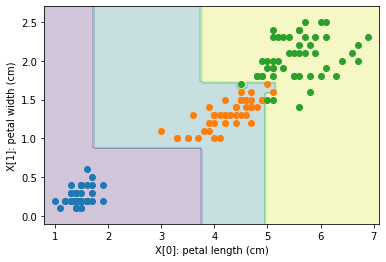

In [170]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    #print(Xdec.shape)
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[2]}")
    plt.ylabel(f"X[1]: {iris.feature_names[3]}")
    plt.show()

plotDecisao(MinhaArvore(), X, y)

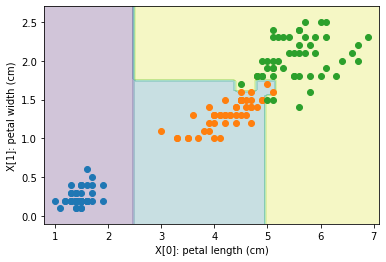

In [171]:
plotDecisao(ArvoreAula(), X, y)

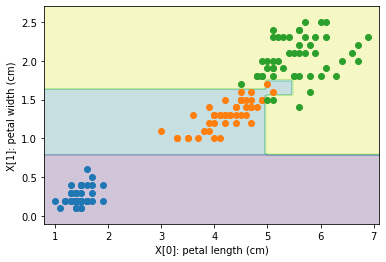

In [172]:
plotDecisao(DecisionTreeClassifier(), X, y)

# Escreva um parágrafo expondo sua interpretação dos resultados obtidos

Comparando a acurácia dos modelos desenvolvidos(o meu, o último apresentado na aula e o do Sklearn), vemos que os 3 modelos apresentam práticamente a mesma acurácia, tanto usando re-substituição quanto usando a validação cruzada. A única diferença de acurácia na validação cruzada foi na última casa; o último dígito da minha árvore é 5 enquanto as outras 2 o último dígito é 4. Isso mostra que os modelos estão muito parecidos. 

Observei nos gráficos que a região de decisão dos algortimos varia muito. Em algumas situações, a árvore do Sklearn e a árvore apresentada na aula tiveram gráficos semelhantes, diferentemente da minha árvore. Os resultados me levam a entender que o bom desempenho dos algoritmos foi porque eles "gravaram" os dados (overfitting). Um exemplo bem diferente dos que estão na base de dados possívelmente geraria um previsão errada. 

# Base de dados: Classificação de tipos de vidro

1 building windows float processed 
2 building windows non floatprocessed
3 vehicle windows float processed
4 vehicle windows non floatprocessed (none in this database)
5 containers
6 tableware
7 headlamps


In [173]:
data = pd.read_csv('glass.csv')
X = data.to_numpy()
y = X[:, -1:]
X = X[:, :-1]
X.shape, y.shape

((214, 9), (214, 1))

In [174]:
score_cv_arvore_aula = cross_validate(ArvoreAula(), X, y)
print('ArvoreAula -> Acurácia com validação cruzada: ', np.mean(score_cv_arvore_aula['test_score']))

score_cv_tree_sklearn = cross_validate(DecisionTreeClassifier(), X, y)
print('Arvore Sklearn -> Acurácia com validação cruzada: ', np.mean(score_cv_tree_sklearn['test_score']))

score_cv = cross_validate(MinhaArvore(), X, y)
print('MinhaArvore -> Acurácia com validação cruzada: ', np.mean(score_cv['test_score']))

ArvoreAula -> Acurácia com validação cruzada:  nan
Arvore Sklearn -> Acurácia com validação cruzada:  0.5702104097452935
MinhaArvore -> Acurácia com validação cruzada:  0.5754152823920266


# Base de dados: Detecção de doença do coração

In [175]:
data = pd.read_csv('heart.csv')
X = data.to_numpy()
y = X[:, -1:]
X = X[:, :-1]
X.shape, y.shape

((303, 13), (303, 1))

In [176]:
score_cv_arvore_aula = cross_validate(ArvoreAula(), X, y)
print('ArvoreAula -> Acurácia com validação cruzada: ', np.mean(score_cv_arvore_aula['test_score']))

score_cv_tree_sklearn = cross_validate(DecisionTreeClassifier(), X, y)
print('Arvore Sklearn -> Acurácia com validação cruzada: ', np.mean(score_cv_tree_sklearn['test_score']))

score_cv = cross_validate(MinhaArvore(), X, y)
print('MinhaArvore -> Acurácia com validação cruzada: ', np.mean(score_cv['test_score']))

ArvoreAula -> Acurácia com validação cruzada:  nan
Arvore Sklearn -> Acurácia com validação cruzada:  0.7621857923497268
MinhaArvore -> Acurácia com validação cruzada:  0.7721857923497268


# Base de dados: 

In [177]:
data = pd.read_csv('winequality-white.csv')
X = data.to_numpy()
y = X[:, -1:]
X = X[:, :-1]
print(X.shape, y.shape)

(4898, 11) (4898, 1)


"\ny = data['quality']\nX = data.drop('quality', axis=1)\nX.shape, y.shape\n"

In [178]:
score_cv_arvore_aula = cross_validate(ArvoreAula(), X, y)
print('ArvoreAula -> Acurácia com validação cruzada: ', np.mean(score_cv_arvore_aula['test_score']))

score_cv_tree_sklearn = cross_validate(DecisionTreeClassifier(), X, y)
print('Arvore Sklearn -> Acurácia com validação cruzada: ', np.mean(score_cv_tree_sklearn['test_score']))

score_cv = cross_validate(MinhaArvore(), X, y)
print('MinhaArvore -> Acurácia com validação cruzada: ', np.mean(score_cv['test_score']))

ArvoreAula -> Acurácia com validação cruzada:  nan
Arvore Sklearn -> Acurácia com validação cruzada:  0.42385378666277546
MinhaArvore -> Acurácia com validação cruzada:  0.4152790227429072
